# Dense neural network
Author: Javier Duarte

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [1]:
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
h5file = {}
params = {}
df = {}

filename['VV'] = 'data/ntuple_4mu_VV.h5'
filename['bkg'] = 'data/ntuple_4mu_bkg.h5'

h5file['VV'] = h5py.File(filename['VV'], 'r') # open read-only
params['VV'] = h5file['VV'][treename][()]
h5file['bkg'] = h5py.File(filename['bkg'], 'r') # open read-only
params['bkg'] = h5file['bkg'][treename][()]

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-pippkgs_depscipy/3.0-omkpbe4/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define the model
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The weights are initialized using a small Gaussian random number. 
We will switch between linear and tanh activation functions for the hidden layer.
The output layer contains a single neuron in order to make predictions. 
It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [2]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils

NDIM = len(VARS)
inputs = Input(shape=(NDIM,), name = 'input')    
x = Dense(5, name = 'dense_1', kernel_initializer='glorot_uniform', activation='tanh')(inputs)
x = Dense(5, name = 'dense_2', kernel_initializer='glorot_uniform', activation='tanh')(x)
predictions = Dense(1, name = 'output', kernel_initializer='glorot_uniform', activation='sigmoid')(x)
#predictions = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(inputs)
# creae the model
model = Model(inputs=inputs, outputs=predictions)
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
output (Dense)               (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). We will also define our early stopping criteria to prevent over-fitting.

In [3]:
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Run training 
Here, we run the training.

In [4]:
# Train classifier
history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=600, 
                    batch_size=1024, 
                    verbose=1, 
                    callbacks=[early_stopping], 
                    validation_split=0.25)

Train on 12442 samples, validate on 4148 samples
Epoch 1/600
12442/12442 [==============================] - 1s 40us/step - loss: 0.6439 - acc: 0.6800 - val_loss: 0.6324 - val_acc: 0.7191
Epoch 2/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.6229 - acc: 0.7406 - val_loss: 0.6115 - val_acc: 0.7674
Epoch 3/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.6021 - acc: 0.7887 - val_loss: 0.5907 - val_acc: 0.8120
Epoch 4/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.5812 - acc: 0.8309 - val_loss: 0.5694 - val_acc: 0.8486
Epoch 5/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.5596 - acc: 0.8652 - val_loss: 0.5470 - val_acc: 0.8886
Epoch 6/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.5368 - acc: 0.9024 - val_loss: 0.5234 - val_acc: 0.9272
Epoch 7/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.5129 - acc: 0.9363 - val_loss: 0.4987 - val_acc

Epoch 60/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1893 - acc: 0.9497 - val_loss: 0.1790 - val_acc: 0.9527
Epoch 61/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1888 - acc: 0.9496 - val_loss: 0.1785 - val_acc: 0.9527
Epoch 62/600
12442/12442 [==============================] - 0s 4us/step - loss: 0.1883 - acc: 0.9498 - val_loss: 0.1779 - val_acc: 0.9527
Epoch 63/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1878 - acc: 0.9497 - val_loss: 0.1774 - val_acc: 0.9525
Epoch 64/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1873 - acc: 0.9497 - val_loss: 0.1768 - val_acc: 0.9525
Epoch 65/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1868 - acc: 0.9497 - val_loss: 0.1763 - val_acc: 0.9525
Epoch 66/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1863 - acc: 0.9497 - val_loss: 0.1758 - val_acc: 0.9525
Epoch 67/600
12442/12442 [========

12442/12442 [==============================] - 0s 3us/step - loss: 0.1602 - acc: 0.9513 - val_loss: 0.1489 - val_acc: 0.9554
Epoch 120/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1597 - acc: 0.9514 - val_loss: 0.1485 - val_acc: 0.9556
Epoch 121/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1592 - acc: 0.9513 - val_loss: 0.1479 - val_acc: 0.9554
Epoch 122/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1588 - acc: 0.9513 - val_loss: 0.1475 - val_acc: 0.9554
Epoch 123/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1583 - acc: 0.9515 - val_loss: 0.1470 - val_acc: 0.9554
Epoch 124/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1578 - acc: 0.9514 - val_loss: 0.1465 - val_acc: 0.9554
Epoch 125/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1573 - acc: 0.9515 - val_loss: 0.1460 - val_acc: 0.9554
Epoch 126/600
12442/12442 [==============

Epoch 178/600
12442/12442 [==============================] - 0s 4us/step - loss: 0.1158 - acc: 0.9533 - val_loss: 0.1073 - val_acc: 0.9568
Epoch 179/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1147 - acc: 0.9534 - val_loss: 0.1063 - val_acc: 0.9568
Epoch 180/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1136 - acc: 0.9535 - val_loss: 0.1053 - val_acc: 0.9568
Epoch 181/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1124 - acc: 0.9535 - val_loss: 0.1044 - val_acc: 0.9568
Epoch 182/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1113 - acc: 0.9535 - val_loss: 0.1033 - val_acc: 0.9568
Epoch 183/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.1101 - acc: 0.9536 - val_loss: 0.1022 - val_acc: 0.9568
Epoch 184/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.1090 - acc: 0.9535 - val_loss: 0.1011 - val_acc: 0.9568
Epoch 185/600
12442/12442 [

Epoch 237/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0682 - acc: 0.9811 - val_loss: 0.0645 - val_acc: 0.9829
Epoch 238/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0678 - acc: 0.9810 - val_loss: 0.0642 - val_acc: 0.9829
Epoch 239/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0674 - acc: 0.9810 - val_loss: 0.0639 - val_acc: 0.9831
Epoch 240/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0670 - acc: 0.9810 - val_loss: 0.0634 - val_acc: 0.9829
Epoch 241/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0666 - acc: 0.9810 - val_loss: 0.0631 - val_acc: 0.9831
Epoch 242/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0663 - acc: 0.9810 - val_loss: 0.0627 - val_acc: 0.9831
Epoch 243/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0659 - acc: 0.9812 - val_loss: 0.0627 - val_acc: 0.9829
Epoch 244/600
12442/12442 [

Epoch 296/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0550 - acc: 0.9832 - val_loss: 0.0526 - val_acc: 0.9841
Epoch 297/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0548 - acc: 0.9832 - val_loss: 0.0525 - val_acc: 0.9841
Epoch 298/600
12442/12442 [==============================] - 0s 4us/step - loss: 0.0547 - acc: 0.9836 - val_loss: 0.0523 - val_acc: 0.9843
Epoch 299/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0546 - acc: 0.9837 - val_loss: 0.0523 - val_acc: 0.9841
Epoch 300/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0545 - acc: 0.9832 - val_loss: 0.0524 - val_acc: 0.9843
Epoch 301/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0544 - acc: 0.9834 - val_loss: 0.0520 - val_acc: 0.9841
Epoch 302/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0543 - acc: 0.9838 - val_loss: 0.0518 - val_acc: 0.9843
Epoch 303/600
12442/12442 [

Epoch 355/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0507 - acc: 0.9841 - val_loss: 0.0487 - val_acc: 0.9841
Epoch 356/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0507 - acc: 0.9841 - val_loss: 0.0487 - val_acc: 0.9838
Epoch 357/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0507 - acc: 0.9839 - val_loss: 0.0487 - val_acc: 0.9838
Epoch 358/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0506 - acc: 0.9842 - val_loss: 0.0487 - val_acc: 0.9836
Epoch 359/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0505 - acc: 0.9842 - val_loss: 0.0488 - val_acc: 0.9836
Epoch 360/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0505 - acc: 0.9842 - val_loss: 0.0486 - val_acc: 0.9838
Epoch 361/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0505 - acc: 0.9842 - val_loss: 0.0485 - val_acc: 0.9838
Epoch 362/600
12442/12442 [

Epoch 414/600
12442/12442 [==============================] - 0s 3us/step - loss: 0.0489 - acc: 0.9842 - val_loss: 0.0472 - val_acc: 0.9834
Epoch 415/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0490 - acc: 0.9842 - val_loss: 0.0476 - val_acc: 0.9829
Epoch 416/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0489 - acc: 0.9843 - val_loss: 0.0475 - val_acc: 0.9829
Epoch 417/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0489 - acc: 0.9842 - val_loss: 0.0474 - val_acc: 0.9829
Epoch 418/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0488 - acc: 0.9842 - val_loss: 0.0473 - val_acc: 0.9831
Epoch 419/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0488 - acc: 0.9842 - val_loss: 0.0474 - val_acc: 0.9831
Epoch 420/600
12442/12442 [==============================] - 0s 2us/step - loss: 0.0488 - acc: 0.9844 - val_loss: 0.0474 - val_acc: 0.9829


## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

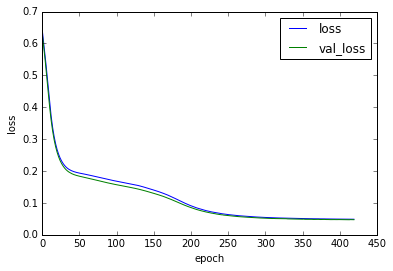

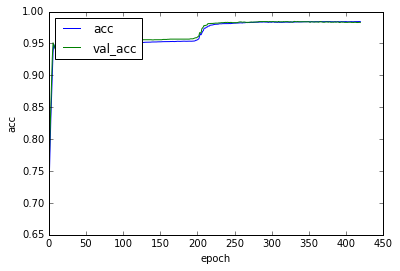

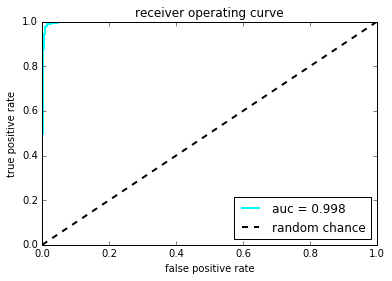

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss vs epoch
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')

# plot accuracy vs epoch
plt.figure()
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend(loc="upper left")
plt.xlabel('epoch')
plt.ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [6]:
df_all['dense'] = model.predict(X) # add prediction to array
print df_all.iloc[:5]

     f_mass4l     f_massjj  isSignal     dense
0  125.077103  1300.426880       1.0  0.532077
1  124.238113   437.221863       1.0  0.200289
3  124.480667  1021.744080       1.0  0.532077
4  124.919464  1101.381958       1.0  0.532077
7  125.049065   498.717194       1.0  0.200289


# Plot NN output vs input variables

In [7]:
'''
HINT: 
Think about what meshgrid is doing and what myZI should be to make
'''
myX = np.linspace(-5, 5, 100)
myY = np.linspace(-5, 5, 100)
myXI, myYI = np.meshgrid(myX,myY)
myZI = np.array(myXI, copy=True)  
def predict(x, y):
    for i in range(0, len(x)):
        for j in range(0, len(y)):
            #x[i,j] # x value of i, j point
            #y[i,j] # y value of i, j point
            #myZI[i,j] = 0 # change this
            myarray = np.array([x[i,j], y[i,j]])
            myarray = myarray.reshape(1,2)
            myZI[i,j] = model.predict(myarray)
    return myZI
myZI = predict(myXI, myYI)

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


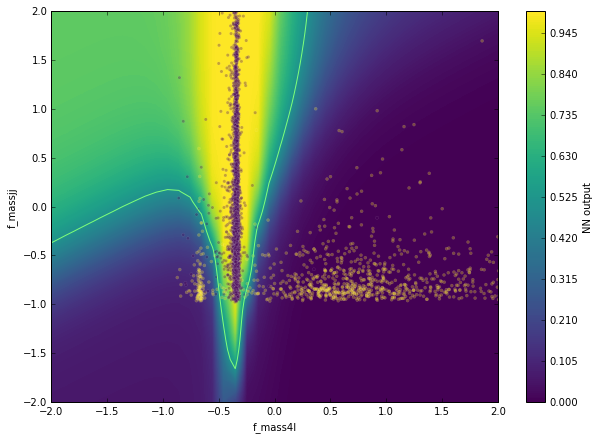

In [8]:
#from matplotlib.axes.Axes import set_xlim
plt.figure(figsize=(10,7))
plt.contourf(myXI,myYI,myZI, 200, cmap='viridis')
plt.colorbar(boundaries=[0,1],label='NN output')
plt.contour(myXI,myYI,myZI, 3, levels=[0,0.5,1])
plt.scatter(X_test[:,0],X_test[:,1], alpha=0.3,c=(1-Y_test),s=10,linewidths=0.2,edgecolor='white',  cmap='viridis')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel(VARS[0])
plt.ylabel(VARS[1])

## Add prediction to `ROOT` trees
Here we'll add the precition we've computed to `ROOT` trees.

In [10]:
from root_numpy import root2array, array2root


def get_features_from_file(filename='', treename='', branches=[]):
    t = root2array(filename, treename=treename, branches=branches) # structured numpy array 
    #print t.shape 
    t = t.view(np.float32).reshape(t.shape + (-1,)) # normal numpy array (trick from https://stackoverflow.com/questions/5957380/convert-structured-array-to-regular-numpy-array)
    #print t.shape
    return t

def write_prediction_to_file(features, model, filename='',treename='',branch=''):
    y_predict_all = model.predict(features) # normal numpy array
    #print y_predict_all.shape
    y_predict_all = np.array(y_predict_all, dtype=[(branch, np.float32)]) # structured numpy array
    #print y_predict_all.shape
    array2root(y_predict_all, filename, treename=treename, mode='recreate')
    
X_all = get_features_from_file('data/ntuple_4mu_VV.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_VV_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')

X_all = get_features_from_file('data/ntuple_4mu_bkg.root', 
                               treename='HZZ4LeptonsAnalysisReduced', 
                               branches=VARS)

X_all = scaler.transform(X_all)

write_prediction_to_file(X_all, 
                         model, 
                         filename='data/ntuple_4mu_bkg_predict.root', 
                         treename='HZZ4LeptonsAnalysisReduced', 
                         branch='dense')